<a href="https://colab.research.google.com/github/Nathan-Bush46/AIPI-Interpretable-ML/blob/main/assignments/Explainable%20Deep%20Learning.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Nathan Bush

### Explainable Deep Learning

In [37]:
# uncomment to get lib it you want
# !pip install torch torchvision tensorflow_datasets grad-cam matplotlib Pillow --quiet
# !apt-get install -y libgl1 --quiet  # needed for OpenCV in pytorch-grad-cam


In [36]:
import tensorflow_datasets as tfds
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights 
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random


In [21]:
# get data
dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [22]:
# =========================
# Used ChatGPT on 2025-10-06 here to get data in right form
# =========================

# Convert TensorFlow dataset into PyTorch tensors for res net 50
tf_to_pil = lambda x, y: (Image.fromarray(x.numpy()), y.numpy())
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create small sample for speed
images, labels = [], []
for x, y in train_ds.take(20):  # just 20 images for demo
    img, label = tf_to_pil(x, y)
    images.append(transform(img))
    labels.append(label)



2025-10-06 06:44:26.499167: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-06 06:44:26.500703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:

X = torch.stack(images)
y = torch.tensor(labels)
print(f"Loaded {len(X)} images with shape {X[0].shape}")

# Load pretrained ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()





Loaded 20 images with shape torch.Size([3, 224, 224])


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
seed = 48  # force the seed so we get some output
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
indices = random.sample(range(len(X)), 5)  # pick 5 random indices
target_layers = [model.layer4[-1]]  # last conv block
# Initialize CAM variants
cams = {
    "GradCAM": GradCAM(model=model, target_layers=target_layers),
    "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layers),
    "XGradCAM": XGradCAM(model=model, target_layers=target_layers)
}


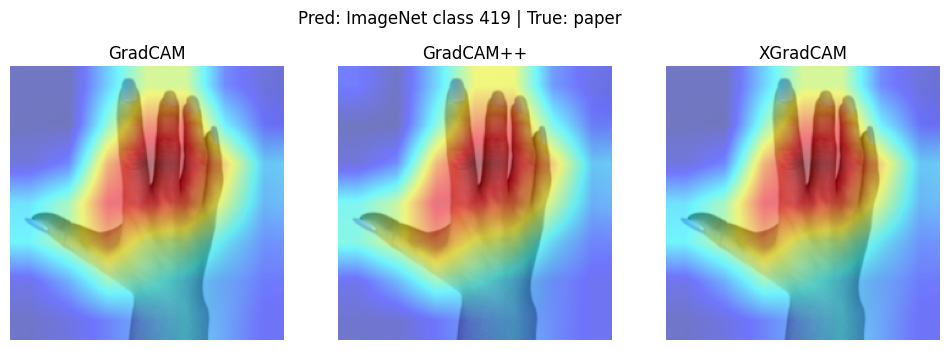

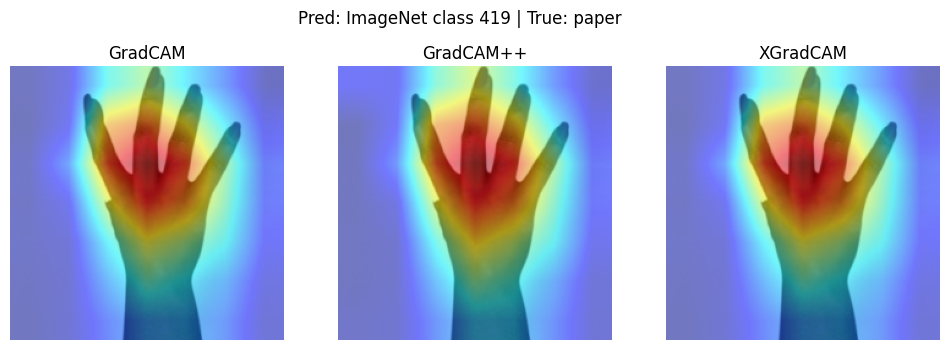

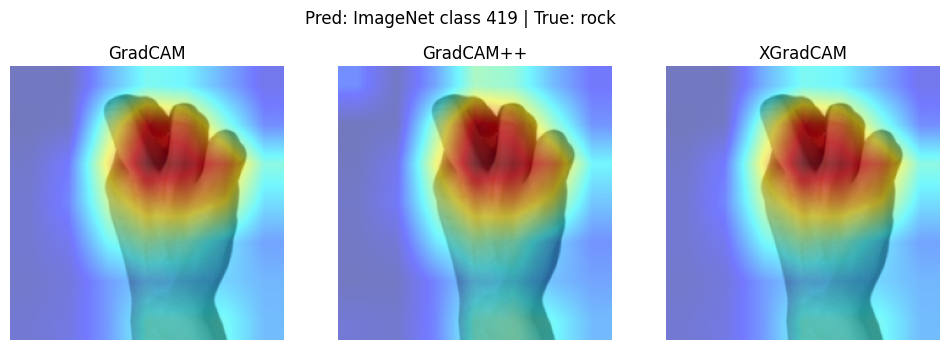

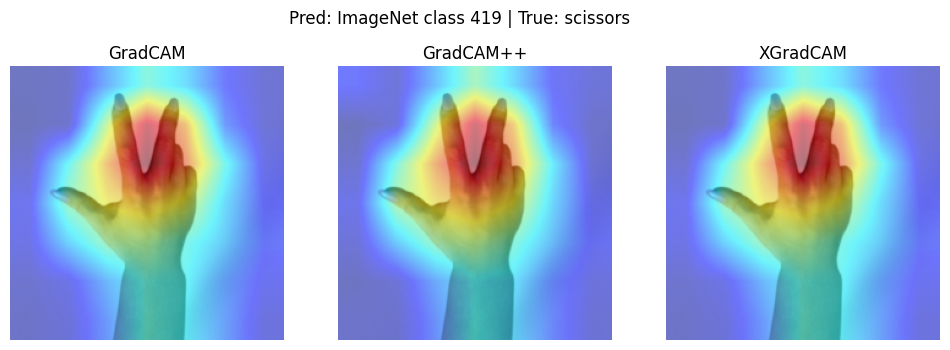

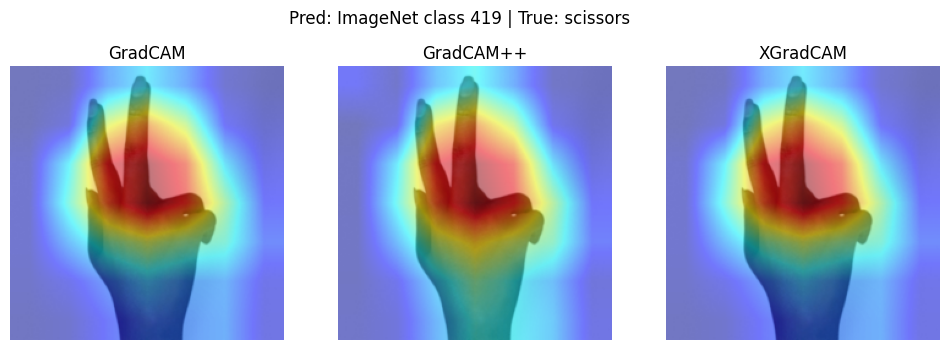

In [35]:
# =========================
# Used ChatGPT on 2025-10-06 to use grad cam with images that are pretty + show predictions
# =========================
# Run GradCAM variants on 5 random images
import torch.nn.functional as F

class_names = info.features["label"].names  # from TFDS metadata

for i, idx in enumerate(indices):
    input_tensor = X[idx].unsqueeze(0)
    rgb_img = X[idx].permute(1, 2, 0).numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Get prediction from pretrained model (I just wanted to see I know it was not trained for this)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_class = probs.argmax(dim=1).item()

    true_label = y[idx].item()
    title_text = f"Pred: ImageNet class {pred_class} | True: {class_names[true_label]}"
# (Used ChatGPT)

    plt.figure(figsize=(12, 4))
    for j, (name, cam) in enumerate(cams.items()):
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(1, 3, j + 1)
        plt.imshow(vis)
        plt.axis("off")
        plt.title(name)
    plt.suptitle(title_text)
    plt.show()
# (Used ChatGPT)


# Compare of the attention maps generated by GradCAM and its variants.

So as you can see above, the attention maps are rather similar for GradCAM, GradCAM++, and XGradCAM. They all highlight the hand and some space around it, focusing on the fingers and knuckles. Note (red = high importance, blue = low).

* GradCAM looks like it just gives a clear idea of where the model is looking.
* GradCAM++’s main difference is that it highlights a bit more of the hand/lower arm as being important compared to the others.
* XGradCAM is very similar to GradCAM, but the noise or “cloud” around the hand is a tiny bit different, maybe less pronounced.






#  Analysis of GradCAM Results/reflection

- Whether the model focused on appropriate cues

-  Any surprising or misleading results

- The significance of explainability in your chosen domain


###

All of the GradCAMs show that, in these images, the model focused around the fingers and knuckles. This is generally a logical place for most of the model’s attention for a rock–paper–scissors task.

That said, this is a **ResNet** model that wasn’t tuned for this task, so it predicted the class to be *band-aids* according to [this reference](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

What that means is that ResNet may have learned to associate fingers held out—like in this image—with band-aids. This isn’t ideal, as it suggests the model might have developed a bias linking human hands with band-aids. However, since this output space is completely different from the one the model was originally trained for, I wouldn’t expect it to remain an issue after fine-tuning the output layer for this task.

I think in this case, the explainability helps show that the model isn’t “wrong” in what it looks at, just in how it labels it. 






Note the writing above is my onw but I spell checked and formated with chatgpt.